In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path = "../data/cleaned_data/resales_processed_"
resales_frames = [pd.read_csv(f"{path}{letter}") for letter in
                  ['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj']]

columns = resales_frames[0].columns
for df in resales_frames:
    df.columns = columns

resales = pd.concat(resales_frames, axis=0, ignore_index=True)

In [3]:
print(resales.columns)

Index(['month_sold', 'year_sold', 'town', 'block', 'street_name', 'building',
       'address', 'postal', 'flat_type', 'flat_model', 'storey_range',
       'average_storey', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'price_per_sqm', 'lat', 'lng',
       'nearest_station', 'station_dist', 'nearest_school_dist',
       'nearest_school', 'nearest_mall', 'nearest_mall_dist', 'nearest_hawker',
       'nearest_hawker_dist', 'nearest_supermarket',
       'nearest_supermarket_dist', 'nearest_amenity', 'nearest_amenity_dist',
       'max_floor_lvl'],
      dtype='object')


In [4]:
resales.dtypes

month_sold                   object
year_sold                     int64
town                         object
block                        object
street_name                  object
building                     object
address                      object
postal                        int64
flat_type                    object
flat_model                   object
storey_range                 object
average_storey                int64
floor_area_sqm              float64
lease_commence_date           int64
remaining_lease               int64
resale_price                float64
price_per_sqm               float64
lat                         float64
lng                         float64
nearest_station              object
station_dist                float64
nearest_school_dist         float64
nearest_school               object
nearest_mall                 object
nearest_mall_dist           float64
nearest_hawker               object
nearest_hawker_dist         float64
nearest_supermarket         

In [5]:
# Included Year_sold, Month_sold
# Used OrdinalEncode, OneHotEncode

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# convert month_sold to datetime format
resales['month_sold'] = pd.to_datetime(resales['month_sold'])
# extract month from month_sold
resales['month_sold'] = resales['month_sold'].dt.month

# Define the columns for different transformations
categorical_features = ['month_sold', 'town', 'flat_type', 'flat_model']
ordinal_features = ['year_sold']
numerical_features = ['floor_area_sqm', 'average_storey', 'remaining_lease', 'nearest_school_dist', 'station_dist', 'nearest_amenity_dist', 'max_floor_lvl']

# Define transformers
categorical_transformer = OneHotEncoder()
ordinal_transformer = OrdinalEncoder(categories=[sorted(resales['year_sold'].unique())])
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', MinMaxScaler())
])

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

Train MSE: 465377340.33491915
Test MSE: 592470046.136163
Train R^2: 0.9834132524700431
Test R^2: 0.9787170265840456

Train MAE: 15969.816187944356
Test MAE: 17264.173447930236
Train RMSE: 21572.606248085074
Test RMSE: 24340.707593169165



<Figure size 1000x500 with 0 Axes>

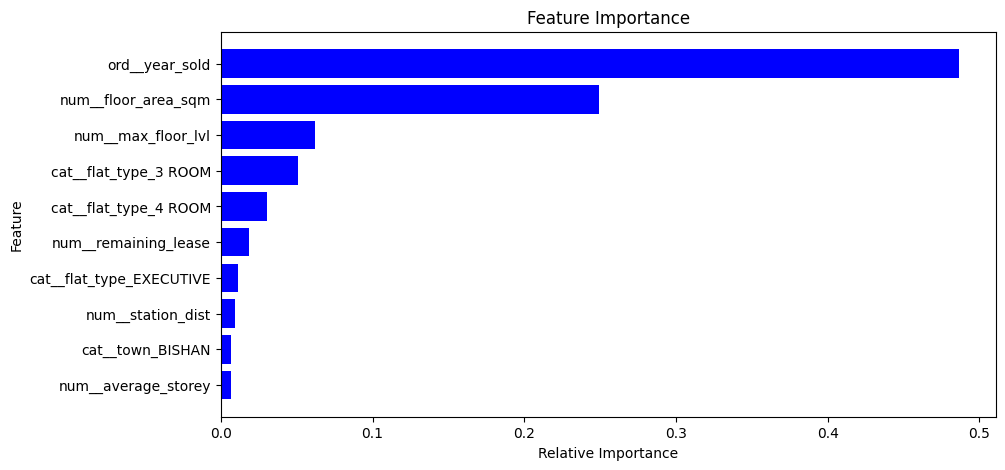

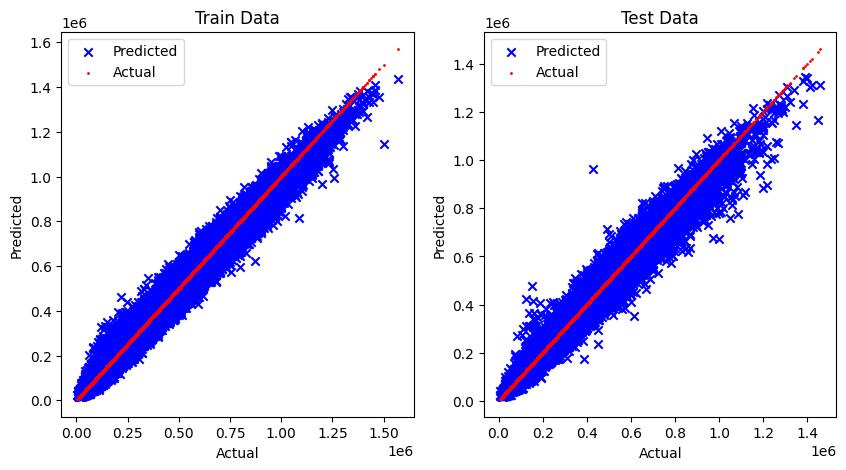

In [6]:
# Random split train-test
# n_estimators=150
# max_depth=9500
# max_leaf_nodes=9501

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import numpy as np

resales_train, resales_test = train_test_split(resales, test_size=0.2, random_state=42)

n_estimators=150
max_depth=9500
max_leaf_nodes=9501

# Create a pipeline with the preprocessor and the RandomForestRegressor
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_samples=0.5, max_features=0.7, random_state=42))

# Splitting the data
resales_train, resales_test = train_test_split(resales, test_size=0.2, random_state=42)
cols_to_drop = [
              'block', 'street_name', 'building', 'address', 'postal', 'storey_range',
              'lease_commence_date', 'resale_price', 'price_per_sqm', 'lat', 'lng',
              'nearest_station', 'nearest_school', 'nearest_mall', 'nearest_mall_dist', 'nearest_hawker',
              'nearest_hawker_dist', 'nearest_supermarket', 'nearest_supermarket_dist', 'nearest_amenity'
              ]
X_train, X_test  = resales_train.drop(columns=cols_to_drop), resales_test.drop(columns=cols_to_drop)
Y_train, Y_test  = resales_train['resale_price'], resales_test['resale_price']

# Fit the model pipeline
rf_pipeline.fit(X_train, Y_train)

# Predictions
Y_train_pred_rf, Y_test_pred_rf = rf_pipeline.predict(X_train), rf_pipeline.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
train_r2 = r2_score(Y_train, Y_train_pred_rf)
test_r2 = r2_score(Y_test, Y_test_pred_rf)
train_mae = mean_absolute_error(Y_train, Y_train_pred_rf)
test_mae = mean_absolute_error(Y_test, Y_test_pred_rf)
train_rmse = sqrt(mean_squared_error(Y_train, Y_train_pred_rf))
test_rmse = sqrt(mean_squared_error(Y_test, Y_test_pred_rf))

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')
print()
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print()

# Feature importance
plt.figure(figsize=(10, 5))
importances = rf_pipeline.named_steps['randomforestregressor'].feature_importances_
feature_names_out = preprocessor.get_feature_names_out()

# Plotting feature importances
plt.figure(figsize=(10, 5))
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names_out[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Plot Y_train vs Y_train_pred and Y_test vs Y_test_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_train, Y_train, color='red', label='Actual', s = 1)
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_test, Y_test, color='red', label='Actual', s = 1)
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.show()

In [7]:
print("Transformed feature names:", feature_names_out)

Transformed feature names: ['cat__month_sold_1' 'cat__month_sold_2' 'cat__month_sold_3'
 'cat__month_sold_4' 'cat__month_sold_5' 'cat__month_sold_6'
 'cat__month_sold_7' 'cat__month_sold_8' 'cat__month_sold_9'
 'cat__month_sold_10' 'cat__month_sold_11' 'cat__month_sold_12'
 'cat__town_ANG MO KIO' 'cat__town_BEDOK' 'cat__town_BISHAN'
 'cat__town_BUKIT BATOK' 'cat__town_BUKIT MERAH' 'cat__town_BUKIT PANJANG'
 'cat__town_BUKIT TIMAH' 'cat__town_CENTRAL AREA'
 'cat__town_CHOA CHU KANG' 'cat__town_CLEMENTI' 'cat__town_GEYLANG'
 'cat__town_HOUGANG' 'cat__town_JURONG EAST' 'cat__town_JURONG WEST'
 'cat__town_KALLANG/WHAMPOA' 'cat__town_MARINE PARADE'
 'cat__town_PASIR RIS' 'cat__town_PUNGGOL' 'cat__town_QUEENSTOWN'
 'cat__town_SEMBAWANG' 'cat__town_SENGKANG' 'cat__town_SERANGOON'
 'cat__town_TAMPINES' 'cat__town_TOA PAYOH' 'cat__town_WOODLANDS'
 'cat__town_YISHUN' 'cat__flat_type_1 ROOM' 'cat__flat_type_2 ROOM'
 'cat__flat_type_3 ROOM' 'cat__flat_type_4 ROOM' 'cat__flat_type_5 ROOM'
 'cat__fl

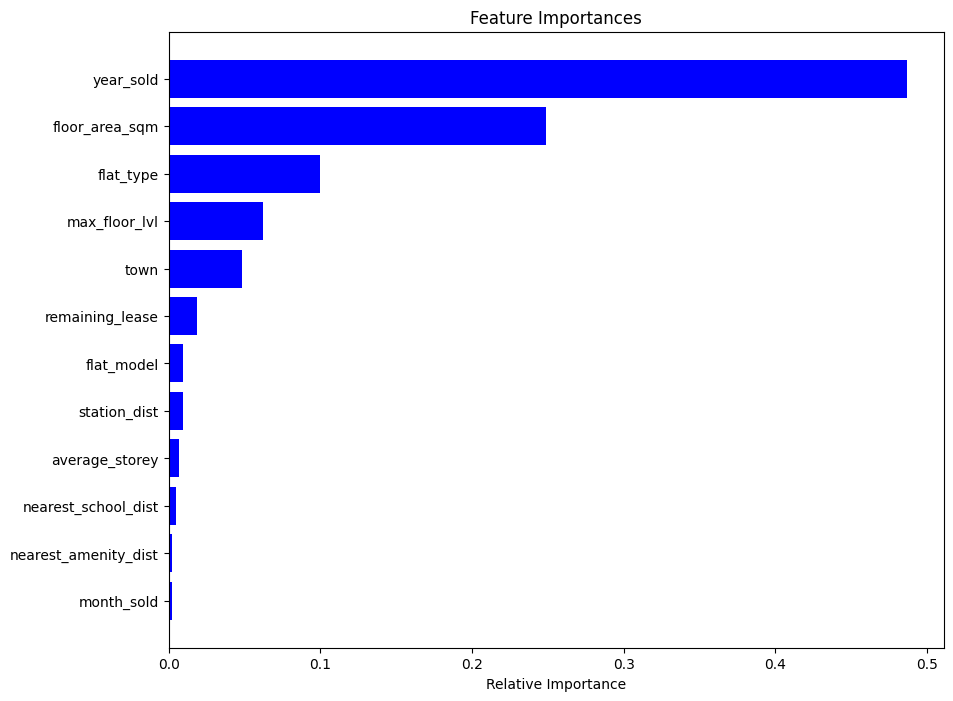

In [8]:
# Feature importance
categorical_importances = {feature: 0.0 for feature in ['month_sold', 'town', 'flat_type', 'flat_model']}
ordinal_importances = {'year_sold': 0.0}
numerical_importances = {feature: 0.0 for feature in ['floor_area_sqm', 'average_storey', 'remaining_lease', 'nearest_school_dist', 'station_dist', 'nearest_amenity_dist']}

# Iterate over each transformed feature name and add its importance to the original feature's sum
for idx, feature_name in enumerate(feature_names_out):
    if feature_name.startswith('cat__month_sold_'):
        categorical_importances['month_sold'] += importances[idx]
    elif feature_name.startswith('cat__town_'):
        categorical_importances['town'] += importances[idx]
    elif feature_name.startswith('cat__flat_type_'):
        categorical_importances['flat_type'] += importances[idx]
    elif feature_name.startswith('cat__flat_model_'):
        categorical_importances['flat_model'] += importances[idx]
    elif feature_name == 'ord__year_sold':
        ordinal_importances['year_sold'] = importances[idx]
    else:
        # For numerical features, we don't need to sum, so we take the importance directly
        num_feature = feature_name.split('__')[1]  # Get the original feature name without prefix
        numerical_importances[num_feature] = importances[idx]

# Combine all importances into a single list for plotting
all_importances = list(categorical_importances.values()) + list(ordinal_importances.values()) + list(numerical_importances.values())
all_features = list(categorical_importances.keys()) + list(ordinal_importances.keys()) + list(numerical_importances.keys())

# Now we can plot the aggregated feature importances
indices = np.argsort(all_importances)
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), [all_importances[i] for i in indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

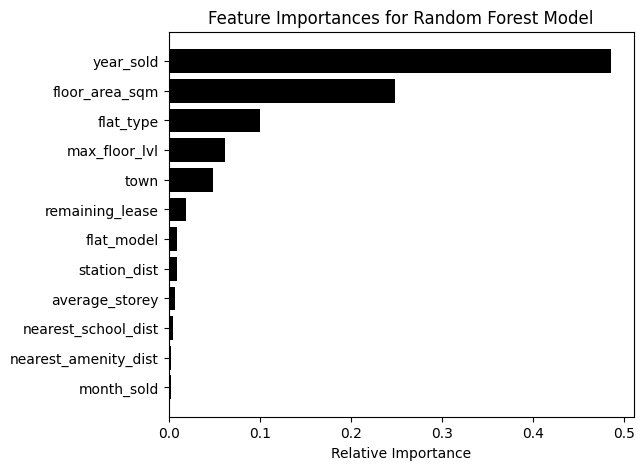

In [9]:
# Now we can plot the aggregated feature importances
indices = np.argsort(all_importances)
plt.figure(figsize=(6, 5))
plt.title('Feature Importances for Random Forest Model')
plt.barh(range(len(indices)), [all_importances[i] for i in indices], color='black', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Text(0, 0.5, 'Residuals')

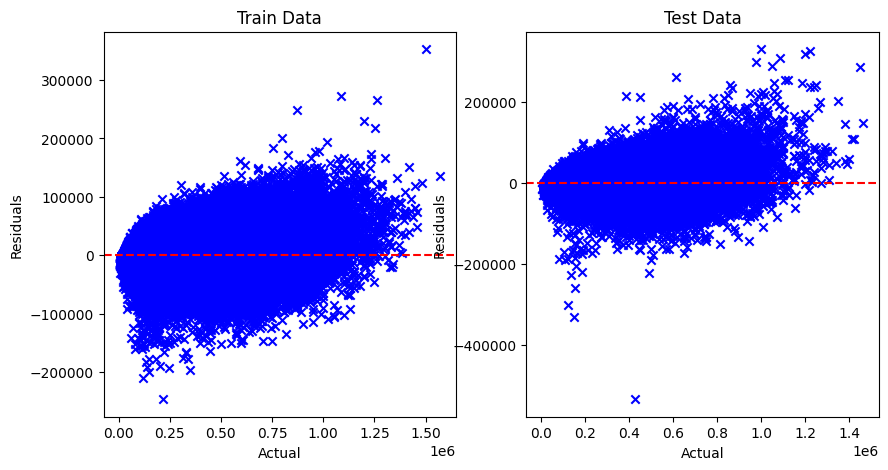

In [10]:
# plot residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

residuals_train = Y_train - Y_train_pred_rf
plt.scatter(Y_train, residuals_train, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
residuals_test = Y_test - Y_test_pred_rf
plt.scatter(Y_test, residuals_test, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

In [11]:
test_errors = pd.DataFrame({'actual': Y_test, 'predicted': Y_test_pred_rf, 'residual': residuals_test})
test_errors['residual'] = test_errors['residual'].abs()
test_errors['percentage_error'] = (test_errors['residual'] / test_errors['actual']) * 100
test_errors['percentage_error'].mean()

6.286997260743876

In [12]:
train_errors = pd.DataFrame({'actual': Y_train, 'predicted': Y_train_pred_rf, 'residual': residuals_train})
train_errors['residual'] = train_errors['residual'].abs()
train_errors['percentage_error'] = (train_errors['residual'] / train_errors['actual']) * 100
train_errors['percentage_error'].mean()

5.963617623792222

In [15]:
# Excluded Year_sold
# Used OneHot Encode

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# convert month_sold to datetime format
resales['month_sold'] = pd.to_datetime(resales['month_sold'])
# extract month from month_sold
resales['month_sold'] = resales['month_sold'].dt.month

# Define the columns for different transformations
categorical_features = ['month_sold', 'town', 'flat_type', 'flat_model']
numerical_features = ['floor_area_sqm', 'average_storey', 'remaining_lease', 'nearest_school_dist', 'station_dist', 'nearest_amenity_dist', 'max_floor_lvl']

# Define transformers
categorical_transformer = OneHotEncoder()
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('normalizer', MinMaxScaler())
])

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

Train MSE: 1145952720.966582
Test MSE: 1400988430.4462135
Train R^2: 0.9591565234992735
Test R^2: 0.9496730683421019

Train MAE: 25375.157304582634
Test MAE: 27248.841841435536
Train RMSE: 33851.92344559733
Test RMSE: 37429.77999462745



<Figure size 1000x500 with 0 Axes>

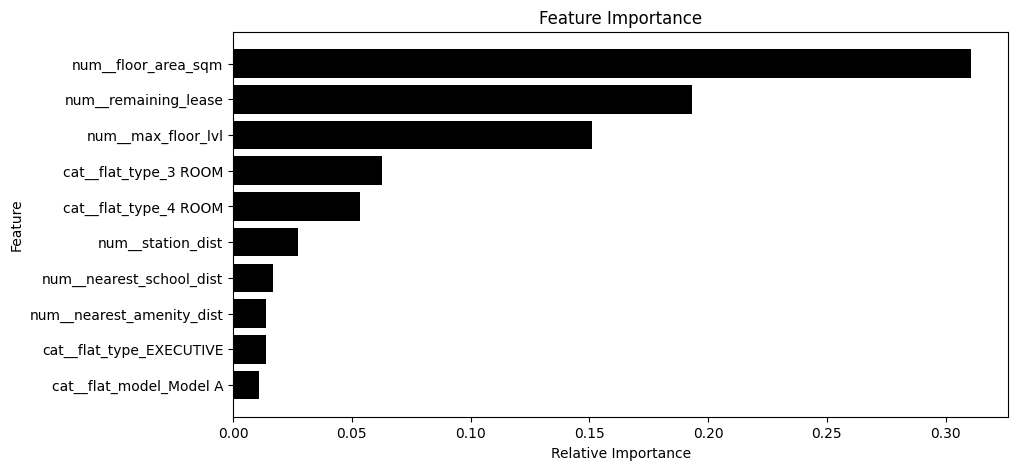

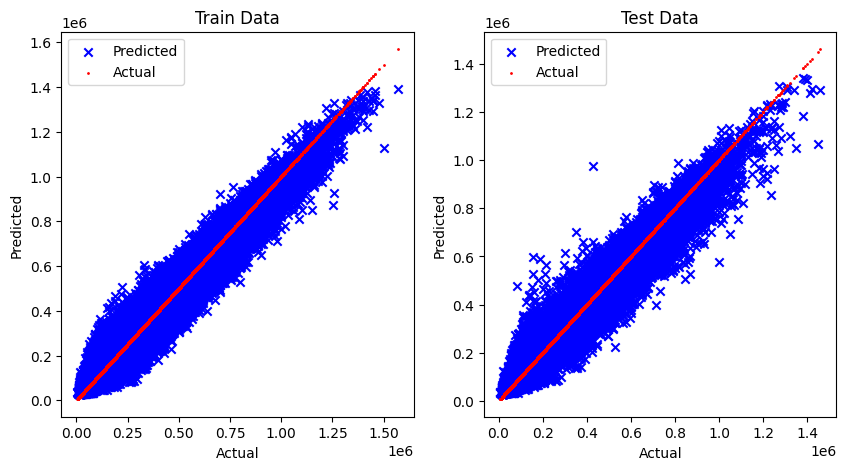

In [16]:
# Random split train-test
# n_estimators=150
# max_depth=9500
# max_leaf_nodes=9501

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import numpy as np

resales_train, resales_test = train_test_split(resales, test_size=0.2, random_state=42)

n_estimators=150
max_depth=9500
max_leaf_nodes=9501

# Create a pipeline with the preprocessor and the RandomForestRegressor
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_samples=0.5, max_features=0.7, random_state=42))

# Splitting the data
resales_train, resales_test = train_test_split(resales, test_size=0.2, random_state=42)
cols_to_drop = [
              'block', 'street_name', 'building', 'address', 'postal', 'storey_range', 'year_sold',
              'lease_commence_date', 'resale_price', 'price_per_sqm', 'lat', 'lng',
              'nearest_station', 'nearest_school', 'nearest_mall', 'nearest_mall_dist', 'nearest_hawker',
              'nearest_hawker_dist', 'nearest_supermarket', 'nearest_supermarket_dist', 'nearest_amenity'
              ]
X_train, X_test  = resales_train.drop(columns=cols_to_drop), resales_test.drop(columns=cols_to_drop)
Y_train, Y_test  = resales_train['resale_price'], resales_test['resale_price']

# Fit the model pipeline
rf_pipeline.fit(X_train, Y_train)

# Predictions
Y_train_pred_rf, Y_test_pred_rf = rf_pipeline.predict(X_train), rf_pipeline.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
train_r2 = r2_score(Y_train, Y_train_pred_rf)
test_r2 = r2_score(Y_test, Y_test_pred_rf)
train_mae = mean_absolute_error(Y_train, Y_train_pred_rf)
test_mae = mean_absolute_error(Y_test, Y_test_pred_rf)
train_rmse = sqrt(mean_squared_error(Y_train, Y_train_pred_rf))
test_rmse = sqrt(mean_squared_error(Y_test, Y_test_pred_rf))

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')
print()
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print()

# Feature importance
plt.figure(figsize=(10, 5))
importances = rf_pipeline.named_steps['randomforestregressor'].feature_importances_
feature_names_out = preprocessor.get_feature_names_out()

# Plotting feature importances
plt.figure(figsize=(10, 5))
indices = np.argsort(importances)[-10:]
plt.barh(range(len(indices)), importances[indices], color='black', align='center')
plt.yticks(range(len(indices)), [feature_names_out[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Plot Y_train vs Y_train_pred and Y_test vs Y_test_pred
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_train, Y_train_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_train, Y_train, color='red', label='Actual', s = 1)
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_test_pred_rf, color='blue', label='Predicted', marker = 'x')
plt.scatter(Y_test, Y_test, color='red', label='Actual', s = 1)
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.show()

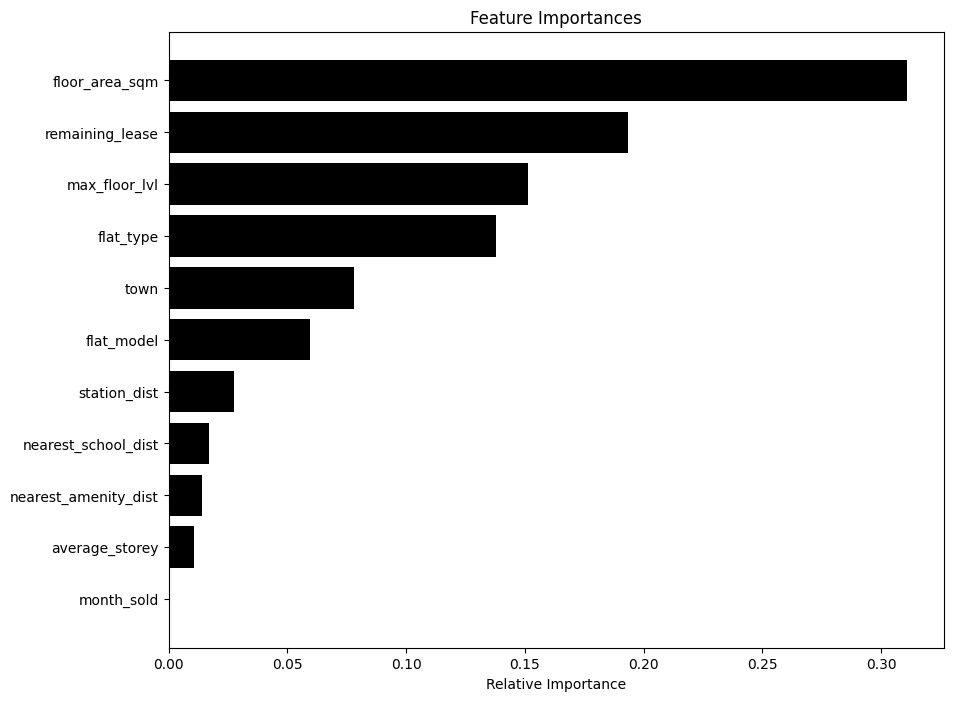

In [17]:
# Feature importance
categorical_importances = {feature: 0.0 for feature in ['month_sold', 'town', 'flat_type', 'flat_model']}
numerical_importances = {feature: 0.0 for feature in ['floor_area_sqm', 'average_storey', 'remaining_lease', 'nearest_school_dist', 'station_dist', 'nearest_amenity_dist']}

# Iterate over each transformed feature name and add its importance to the original feature's sum
for idx, feature_name in enumerate(feature_names_out):
    if feature_name.startswith('cat__month_sold_'):
        categorical_importances['month_sold'] += importances[idx]
    elif feature_name.startswith('cat__town_'):
        categorical_importances['town'] += importances[idx]
    elif feature_name.startswith('cat__flat_type_'):
        categorical_importances['flat_type'] += importances[idx]
    elif feature_name.startswith('cat__flat_model_'):
        categorical_importances['flat_model'] += importances[idx]
    else:
        # For numerical features, we don't need to sum, so we take the importance directly
        num_feature = feature_name.split('__')[1]  # Get the original feature name without prefix
        numerical_importances[num_feature] = importances[idx]

# Combine all importances into a single list for plotting
all_importances = list(categorical_importances.values()) + list(numerical_importances.values())
all_features = list(categorical_importances.keys()) + list(numerical_importances.keys())

# Now we can plot the aggregated feature importances
indices = np.argsort(all_importances)
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), [all_importances[i] for i in indices], color='black', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Text(0, 0.5, 'Residuals')

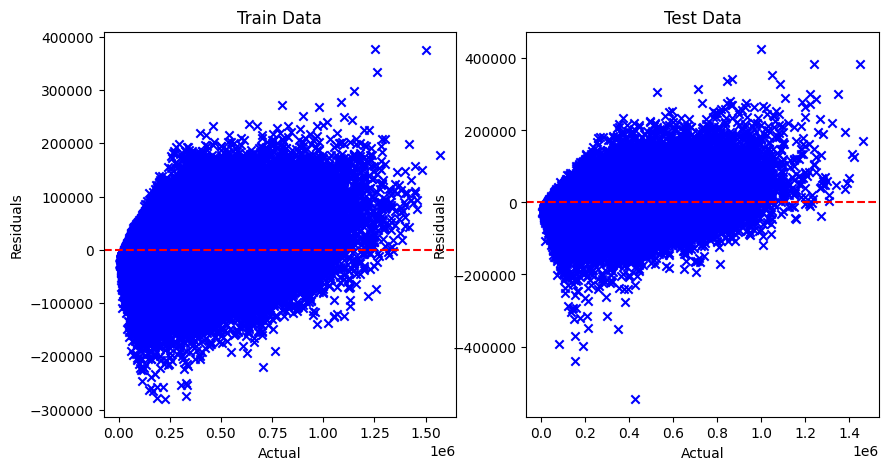

In [19]:
# plot residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

residuals_train = Y_train - Y_train_pred_rf
plt.scatter(Y_train, residuals_train, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Train Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
residuals_test = Y_test - Y_test_pred_rf
plt.scatter(Y_test, residuals_test, color='blue', marker = 'x')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Test Data')
plt.xlabel('Actual')
plt.ylabel('Residuals')

In [20]:
test_errors = pd.DataFrame({'actual': Y_test, 'predicted': Y_test_pred_rf, 'residual': residuals_test})
test_errors['residual'] = test_errors['residual'].abs()
test_errors['percentage_error'] = (test_errors['residual'] / test_errors['actual']) * 100
test_errors['percentage_error'].mean()

10.90738532219575

In [21]:
train_errors = pd.DataFrame({'actual': Y_train, 'predicted': Y_train_pred_rf, 'residual': residuals_train})
train_errors['residual'] = train_errors['residual'].abs()
train_errors['percentage_error'] = (train_errors['residual'] / train_errors['actual']) * 100
train_errors['percentage_error'].mean()

10.269524340199403

In [22]:
# # Train up to 2022, test 2023 and beyond
# # n_estimators=150
# # max_depth=9500
# # max_leaf_nodes=9501

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from math import sqrt
# import numpy as np

# resales_train = resales[resales['year_sold'] < 2023]
# resales_test = resales[resales['year_sold'] >= 2023]

# n_estimators=150
# max_depth=9500
# max_leaf_nodes=9501

# # Create a pipeline with the preprocessor and the RandomForestRegressor
# rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, max_samples=0.5, max_features=0.7, random_state=42))

# # Splitting the data
# resales_train, resales_test = train_test_split(resales, test_size=0.2, random_state=42)
# cols_to_drop = [
#               'block', 'street_name', 'building', 'address', 'postal', 'storey_range',
#               'lease_commence_date', 'resale_price', 'price_per_sqm', 'lat', 'lng',
#               'nearest_station', 'nearest_school', 'nearest_mall', 'nearest_mall_dist', 'nearest_hawker',
#               'nearest_hawker_dist', 'nearest_supermarket', 'nearest_supermarket_dist', 'nearest_amenity'
#               ]
# X_train, X_test  = resales_train.drop(columns=cols_to_drop), resales_test.drop(columns=cols_to_drop)
# Y_train, Y_test  = resales_train['resale_price'], resales_test['resale_price']

# # Fit the model pipeline
# rf_pipeline.fit(X_train, Y_train)

# # Predictions
# Y_train_pred_rf, Y_test_pred_rf = rf_pipeline.predict(X_train), rf_pipeline.predict(X_test)

# train_mse = mean_squared_error(Y_train, Y_train_pred_rf)
# test_mse = mean_squared_error(Y_test, Y_test_pred_rf)
# train_r2 = r2_score(Y_train, Y_train_pred_rf)
# test_r2 = r2_score(Y_test, Y_test_pred_rf)
# train_mae = mean_absolute_error(Y_train, Y_train_pred_rf)
# test_mae = mean_absolute_error(Y_test, Y_test_pred_rf)
# train_rmse = sqrt(mean_squared_error(Y_train, Y_train_pred_rf))
# test_rmse = sqrt(mean_squared_error(Y_test, Y_test_pred_rf))

# print(f'Train MSE: {train_mse}')
# print(f'Test MSE: {test_mse}')
# print(f'Train R^2: {train_r2}')
# print(f'Test R^2: {test_r2}')
# print()
# print(f'Train MAE: {train_mae}')
# print(f'Test MAE: {test_mae}')
# print(f'Train RMSE: {train_rmse}')
# print(f'Test RMSE: {test_rmse}')
# print()

# # Feature importance
# categorical_importances = {feature: 0.0 for feature in ['month_sold', 'town', 'flat_type', 'flat_model']}
# ordinal_importances = {'year_sold': 0.0}
# numerical_importances = {feature: 0.0 for feature in ['floor_area_sqm', 'average_storey', 'remaining_lease', 'nearest_school_dist', 'station_dist', 'nearest_amenity_dist']}

# # Iterate over each transformed feature name and add its importance to the original feature's sum
# for idx, feature_name in enumerate(feature_names_out):
#     if feature_name.startswith('cat__month_sold_'):
#         categorical_importances['month_sold'] += importances[idx]
#     elif feature_name.startswith('cat__town_'):
#         categorical_importances['town'] += importances[idx]
#     elif feature_name.startswith('cat__flat_type_'):
#         categorical_importances['flat_type'] += importances[idx]
#     elif feature_name.startswith('cat__flat_model_'):
#         categorical_importances['flat_model'] += importances[idx]
#     elif feature_name == 'ord__year_sold':
#         ordinal_importances['year_sold'] = importances[idx]
#     else:
#         # For numerical features, we don't need to sum, so we take the importance directly
#         num_feature = feature_name.split('__')[1]  # Get the original feature name without prefix
#         numerical_importances[num_feature] = importances[idx]

# # Combine all importances into a single list for plotting
# all_importances = list(categorical_importances.values()) + list(ordinal_importances.values()) + list(numerical_importances.values())
# all_features = list(categorical_importances.keys()) + list(ordinal_importances.keys()) + list(numerical_importances.keys())

# # Now we can plot the aggregated feature importances
# indices = np.argsort(all_importances)
# plt.figure(figsize=(10, 8))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), [all_importances[i] for i in indices], color='b', align='center')
# plt.yticks(range(len(indices)), [all_features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

# # Plot Y_train vs Y_train_pred and Y_test vs Y_test_pred
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(Y_train, Y_train_pred_rf, color='blue', label='Predicted', marker = 'x')
# plt.scatter(Y_train, Y_train, color='red', label='Actual', s = 1)
# plt.title('Train Data')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.scatter(Y_test, Y_test_pred_rf, color='blue', label='Predicted', marker = 'x')
# plt.scatter(Y_test, Y_test, color='red', label='Actual', s = 1)
# plt.title('Test Data')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.legend()

# plt.show()